In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns

# Load and frame data

Download and unzip data from https://www.kaggle.com/camnugent/sandp500

In [2]:
stocks_files = 'sandp500/all_stocks_5yr.csv'

In [3]:
stocks_df = pd.read_csv(stocks_files)

In [4]:
stocks_df = stocks_df[['date', 'close', 'Name']]

In [5]:
stocks_df['date'] = pd.to_datetime(stocks_df['date'])

In [6]:
stocks_df

,date,close,Name
0,2013-02-08,14.75,AAL
1,2013-02-11,14.46,AAL
2,2013-02-12,14.27,AAL
3,2013-02-13,14.66,AAL
4,2013-02-14,13.99,AAL
...,...,...,...
619035,2018-02-01,77.82,ZTS
619036,2018-02-02,76.78,ZTS
619037,2018-02-05,73.83,ZTS
619038,2018-02-06,73.27,ZTS


Data is in long format, i.e. one stock after antoher. Let's make it wide, i.e. each stock as a different columns.

In [7]:
stocks_df = stocks_df.pivot(index='date', columns='Name', values='close')

Compute returns for each stock. One can use pd.pct_change but log then diff approximation is more approriate in the financial context since it is continuisly compuned.
https://en.wikipedia.org/wiki/Rate_of_return#Logarithmic_or_continuously_compounded_return

In [8]:
returns_df = np.log(stocks_df).diff()

Remove first np.nan observation after pd.diff

In [9]:
returns_df = returns_df[1:]

In [10]:
returns_df.shape

(1258, 505)

In [11]:
returns_df.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.010705,-0.019857,-0.006485,0.010368,-0.011096,-0.002776,-0.004369,-0.003279,-0.012346,0.008281,...,0.002476,-0.001334,-0.003731,-0.000700,0.003762,0.013566,-0.011552,-0.002640,0.002896,0.006334
2013-02-12,0.000448,-0.013227,0.002675,-0.025386,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,...,0.003526,0.003198,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329
2013-02-13,0.002909,0.026963,0.004696,-0.001905,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,...,0.000352,0.005837,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647
2013-02-14,-0.003806,-0.046780,-0.001648,-0.000900,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,...,-0.007062,0.016789,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381
2013-02-15,-0.053681,0.035806,0.002027,-0.013876,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,...,0.015820,-0.008360,-0.001809,-0.002567,-0.007500,-0.006696,0.001564,-0.005780,-0.011844,0.021116


# Clean missing values

How many stocks (columns) have data over all over the period ?

In [12]:
not_null_columns_bool = returns_df.notnull().all() # Series with Boolean equal True if column has all period

In [13]:
returns_df.notnull().all().value_counts()

True     470
False     35
dtype: int64

470, let's continue with these stocks

In [14]:
stocks_list = not_null_columns_bool[not_null_columns_bool].index

In [15]:
returns_df = returns_df[stocks_list]

In [16]:
first_date, last_date = min(returns_df.index), max(returns_df.index)

In [17]:
first_date, last_date

(Timestamp('2013-02-11 00:00:00'), Timestamp('2018-02-07 00:00:00'))

In this experiment, we consider stocks from 2013-02-11 to 2018-02-07

In [18]:
period_in_years = (last_date  - first_date).days / 365

In [19]:
period_in_years

4.991780821917808

# Naive portfolios experiment

In what follow we are interested in returns and covariance in annualized terms (thanks to log + diff) and recalling https://en.wikipedia.org/wiki/Covariance#Covariance_of_linear_combinations

In [20]:
returns_cov = returns_df.cov() / period_in_years 

In [21]:
returns_means = returns_df.mean() / period_in_years

In [22]:
returns_means.mean()

8.402110662930798e-05

Objectif : In what follows, we want to compute the mean performance, i.e. the mean return and the mean volatility, for naive portfolios (weight of each stock is the same in the portfolio) with random stocks. In this experiment we consider portfolios with 1 to 30 stocks. Each number of stocks will be simulated 200 time.

Build the empty pd.DataFrame, with number of stocks only...

In [23]:
diversification_experiment_df = pd.DataFrame({'number_of_stocks': list(range(1, 31, 1))*200})

... that will completed with performances of random naive (weight of a stock = 1/number of stocks) portfolios with this number of stocks. 

In [24]:
def compute_random_naive_portfolio_performances(number_of_stocks, returns_means=returns_means,returns_cov=returns_cov):
    weights = np.array([1/number_of_stocks] * number_of_stocks + [0] * (len(returns_means) - number_of_stocks))
    np.random.shuffle(weights)
    portfolio_return = np.sum(returns_means*weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns_cov, weights)))
    return pd.Series([portfolio_return, portfolio_volatility], index=['return', 'volatility'])



In [25]:
random_naive_portfolio_performances = diversification_experiment_df.number_of_stocks.apply(compute_random_naive_portfolio_performances)



In [26]:
diversification_experiment_df = pd.concat([diversification_experiment_df,
                                           random_naive_portfolio_performances], axis=1)




Which leads to :

In [27]:
diversification_experiment_df

,number_of_stocks,return,volatility
0,1,0.000029,0.006639
1,2,0.000039,0.005257
2,3,0.000163,0.004399
3,4,0.000129,0.004578
4,5,0.000090,0.005683
...,...,...,...
5995,26,0.000106,0.003664
5996,27,0.000104,0.003976
5997,28,0.000097,0.003786
5998,29,0.000117,0.003778


Reading : 
- index 0 is a simulation with one stocks
- index 1 is a simulation with two stocks
- etc

Let's get the mean for each number of stocks

In [28]:
performances_on_stocks_number = diversification_experiment_df.groupby('number_of_stocks')[['return', 'volatility']].mean().reset_index()




And plot it

(7.313258590996096e-05, 0.00010148779613813529)

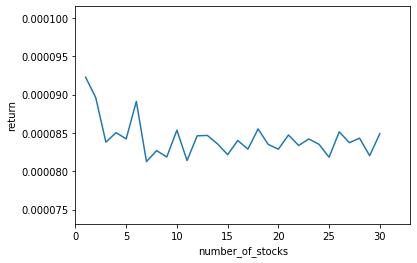

In [29]:
scatter = sns.lineplot(performances_on_stocks_number['number_of_stocks'],
                          performances_on_stocks_number['return'])

axes = scatter.axes

axes.set_xlim(0, 1.1 * performances_on_stocks_number['number_of_stocks'].max())
axes.set_ylim(0.9 * performances_on_stocks_number['return'].min(), 
              1.1 * performances_on_stocks_number['return'].max())

(0, 0.007422781208492936)

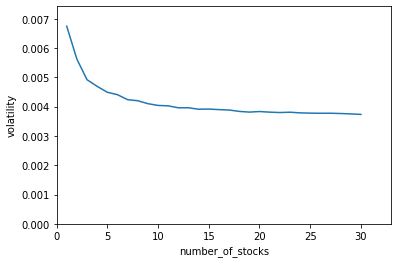

In [30]:
scatter = sns.lineplot(performances_on_stocks_number['number_of_stocks'],
                       performances_on_stocks_number['volatility'])

axes = scatter.axes

axes.set_xlim(0, 1.1 * performances_on_stocks_number['number_of_stocks'].max())
axes.set_ylim(0, 1.1 * performances_on_stocks_number['volatility'].max())


# Take away : 


## The number of stocks in randoms naives portfolios don't affect the return

## Passing from one stock to 5 stocks of randoms naives portfolios decrease the volatility of 55%